[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/notebooks/5.evaluation.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Пайплайн. Подбор threshold

# TO DO
подумать над округлением bbox в предикторе; убрать в дочерних функциях

сделать zip, где можно

Сделать режим выбора скора классификатор или детектор и классификатор, особенно для телебота (ничего, общий, оба)

+ Фильтрацию по трешхолду в отдельную функцию

Возможно округлить уверенности классификатора и произведения

Вариант смены трешхолда в боте

Добавить в отчет наименования знаков

In [1]:
# если работаем в колабе - монтируем диск, ставим fiftyone и kaggle
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install fiftyone -q
    !pip install kaggle -q
    
    colab=True
except:
    colab=False

In [2]:
import os
import sys

import fiftyone as fo
import json
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd
import seaborn as sns
import torch
from fiftyone import ViewField as F
from IPython.display import clear_output
from PIL import Image
#from torchvision.transforms import functional as func

sys.path.append('../src')
from download_datasets import download_RTSD
from execute import Builder

#%matplotlib inline

### Пути к данным и параметры

In [3]:
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(0) if device.type == 'cuda' else device.type)

dataset_path = 'data/raw/RTSD' if colab else os.path.join('..', 'data', 'raw', 'RTSD')
data_prepared_path = '../content/drive/MyDrive/TSR/data/prepared' if colab else os.path.join('..', 'data', 'prepared')
models_path = '../content/drive/MyDrive/TSR/models' if colab else os.path.join('..', 'models')
metrics_path = '../content/drive/MyDrive/TSR/data/metrics' if colab else os.path.join('..', 'data', 'metrics')

detector_file = 'chkpt_detector_resnet50_v2_augmented_b8_5.pth'
classifier_file = 'classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth'

#detector_threshold = 0
#classifier_threshold = 0
#multiplication_threshold = 0
#debug_mode = False

NVIDIA GeForce RTX 3090


In [4]:
# если работаем в колабе - скачиваем и распаковываем датасет
if colab==True:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    
    !kaggle datasets download watchman/rtsd-dataset
    
    !mkdir -p data/raw/RTSD
    !unzip -q rtsd-dataset.zip -d ./data/raw/RTSD/
    !rm rtsd-dataset.zip
    !cp -r data/raw/RTSD/rtsd-frames/rtsd-frames/ data/raw/RTSD
    !rm -r data/raw/RTSD/rtsd-frames/rtsd-frames/

# если работаем локально и датасет не скачан - скачиваем
elif os.path.exists(dataset_path) == False:
    download_RTSD(dataset_path)

### Загрузка модели (детектор и классификатор)

In [5]:
'''model = Builder(device=device,
                class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                detector_path=os.path.join(models_path, detector_file),
                classifier_path=os.path.join(models_path, classifier_file),
                detector_threshold=0.,
                classifier_threshold=0.,
                multiplication_threshold=0.,
                debug_mode=False)'''

"model = Builder(device=device,\n                class2label_path = os.path.join(data_prepared_path, 'label_map.json'),\n                label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),\n                detector_path=os.path.join(models_path, detector_file),\n                classifier_path=os.path.join(models_path, classifier_file),\n                detector_threshold=0.,\n                classifier_threshold=0.,\n                multiplication_threshold=0.,\n                debug_mode=False)"

## Вспомогательные функции

In [5]:
def load_dataset(data_path, anno_path):
    
    print('Загрузка датасета', anno_path)
    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,    # The directiry containing the source images
        labels_path=anno_path,   # The path to the COCO labels JSON file
        #progress=False
    )
    # Rename detections to ground_truth
    dataset.rename_sample_field("detections", "ground_truth")
    #dataset = dataset.take(500)
    return dataset

#dataset_val = load_dataset(dataset_path, os.path.join(dataset_path, 'val_anno.json'))

In [6]:
def add_detection_fo_dataset(model, dataset, detector_threshold=None, classifier_threshold=None, multiplication_threshold=None, visual_score_mode: str = 'multiplication'):
    # Add and evaluating Faster-RCNN detections
    # Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field
    #classes = dataset.default_classes
   
    # Add predictions
    for i, sample in enumerate(dataset):
        
        img = Image.open(sample.filepath)
        h, w = img.height, img.width

        bboxes, pred_labels, pred_detector_scores, pred_classifier_scores, multiplication_thresholds = model.predict_single(img, detector_threshold, classifier_threshold,
                                                                                                                            multiplication_threshold, debug_mode=False)
        detections = []
        for bbox, label, detector_score, classifier_score, multiplication_score in zip(bboxes, pred_labels, pred_detector_scores, pred_classifier_scores, multiplication_thresholds):
            label_id = model.class2label_map[label]
            #label_name = model.labels2names_map[label_id]
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]   
            #score = detector_score*classifier_score if visual_score_mode=='multiplication' else classifier_score
            score = multiplication_score if visual_score_mode=='multiplication' else classifier_score
            detections.append(fo.Detection(label=label_id,
                                           bounding_box=rel_box,
                                           confidence=score))
        
        sample['detections'] = fo.Detections(detections=detections)
        sample.save()
            
        if i % 10 == 0:
            print(f"\tОбработано {i} из {dataset.__len__()} сэмплов.", end='\r')
    print(f"\tОбработано {dataset.__len__()} сэмплов." + ' '*10)

    return dataset

#dataset_val = add_detection_fo_dataset(model, dataset_val, detector_threshold = 0, classifier_threshold = 0, multiplication_threshold = 0)

In [7]:
def plot_metrics_single(metrics_all):

    plt.plot(metrics_all['threshold'], metrics_all['recall'],    color='b', label='Recall')
    plt.plot(metrics_all['threshold'], metrics_all['fscore'],    color='r', label='F1 score')
    plt.plot(metrics_all['threshold'], metrics_all['precision'], color='g', label='Precision')
    plt.plot(metrics_all['threshold'], metrics_all['accuracy'],  color='k', label='Accuracy')
    #plt.plot(threshold_plot, mAP_plot, color='y', label='mAP')

    plt.xlabel("threshold")
    plt.ylabel("metrics")
    plt.title("Threshold")
    plt.legend()
    plt.show()

    return None

In [8]:
def get_metrics_threshold(dataset_with_pred, list_threshold, visualized_single=False):
    
    metrics_all = {'threshold':[],'accuracy':[], 'precision':[], 'recall':[], 'fscore':[], 'mAP':[]}

    for threshold in list_threshold:
        
        high_conf_fp_view = dataset_with_pred.filter_labels("detections", (F("confidence") > threshold), only_matches=False)
        results = high_conf_fp_view.evaluate_detections("detections",
                                                        gt_field="ground_truth",
                                                        eval_key="eval",
                                                        compute_mAP=True,
                                                        progress=True,
                                                        verbose=False
                                                        )
        clear_output(True)

        metrics = results.metrics()
        metrics['mAP'] = results.mAP()

        metrics_all['threshold']  = metrics_all['threshold']  + [threshold]
        metrics_all['accuracy']   = metrics_all['accuracy']   + [metrics['accuracy']]
        metrics_all['precision']  = metrics_all['precision']  + [metrics['precision']]
        metrics_all['recall']     = metrics_all['recall']     + [metrics['recall']]
        metrics_all['fscore']     = metrics_all['fscore']     + [metrics['fscore']]
        metrics_all['mAP']        = metrics_all['mAP']        + [metrics['mAP']]

        if visualized_single==True:
            plot_metrics_single(metrics_all)

    return metrics_all

#threshold_multiplication_metrics = get_metrics_threshold(dataset_val, list_threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
#                                                         visualized_single=True)  

In [9]:
def plot_metrics_matrix(df):
    
    #rep.style.background_gradient(cmap='viridis')

    # Установка размера фигуры
    plt.rcParams['figure.figsize']=(df.shape[1], df.shape[0]/2)
    
    # Создание тепловой карты
    heatmap = sns.heatmap(
        df,
        annot=True,
        fmt='.4g',

        cmap="RdYlGn",  # использовать синюю цветовую карту      # Greens crest
        cbar_kws={"fraction": 0.01},  # боковой колор-бар (shrink colour bar)
        linewidth=2,  # пространство между клетками
    )
    # Настройка меток по оси X
    heatmap.set_xticklabels(
        heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    
    # Добавление меток осей
    heatmap.set_xlabel("Classifier threshold")
    heatmap.set_ylabel("Detector threshold")
    
    # Добавление заголовка
    plt.title("F1 score")

    # Показ тепловой карты
    plt.show()

    return None

## Метрики модели для разных порогов произведения уверенностей

In [10]:
def metrics_thresholds_multiplication(detector_file, classifier_file, multiplication_thresholds, visualized=True, file_save: str = None):
    
    model = Builder(device=device,
                    class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                    label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                    detector_path=os.path.join(models_path, detector_file),
                    classifier_path=os.path.join(models_path, classifier_file),
                    detector_threshold=0.,
                    classifier_threshold=0.,
                    multiplication_threshold=0.,
                    debug_mode=False)
    
    dataset_val = load_dataset(dataset_path, os.path.join(dataset_path, 'val_anno.json'))
    dataset_val = add_detection_fo_dataset(model, dataset_val, visual_score_mode='multiplication')      # попробовать заменить на None
    metrics = {'detector': detector_file,
               'classifier': classifier_file}
    metrics = {**metrics, **get_metrics_threshold(dataset_val, list_threshold=multiplication_thresholds, visualized_single=visualized)}

    best_f1 = max(metrics['fscore'])
    best_threshhold = metrics['threshold'][metrics['fscore'].index(best_f1)]
    print(f'Наилучший F1 {best_f1:.4f} с multiplication threshold {best_threshhold}')
    
    if file_save:
        with open(os.path.join(metrics_path, file_save), 'w') as f:
            json.dump(metrics, f)

    return metrics

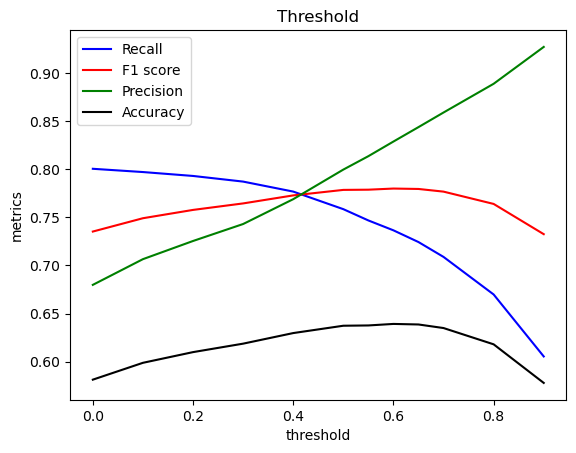

Наилучший F1 0.7799 с multiplication threshold 0.6


In [11]:
threshold_multiplication_metrics = metrics_thresholds_multiplication(detector_file, classifier_file,
                                                                     multiplication_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.9],
                                                                     visualized=True, file_save='threshold_multiplication_metrics.json')

Удалить

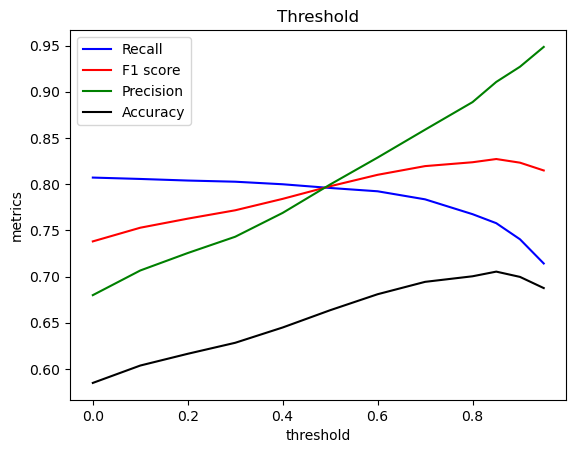

Наилучший F1 0.8272 с multiplication threshold 0.85


In [21]:
threshold_multiplication_metrics = metrics_thresholds_multiplication(detector_file, classifier_file,
                                                                     multiplication_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
                                                                     visualized=True, file_save='threshold_multiplication_metrics.json')

## Метрики модели для разных порогов произведения уверенностей детектора и классификатора

In [12]:
def metrics_thresholds_dtc_clf(detector_file, classifier_file, detector_thresholds, classifier_thresholds, visualized=True, file_save: str = None):
    
    model = Builder(device=device,
                    class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                    label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                    detector_path=os.path.join(models_path, detector_file),
                    classifier_path=os.path.join(models_path, classifier_file),
                    detector_threshold=0.,
                    classifier_threshold=0.,
                    multiplication_threshold=0.,
                    debug_mode=False)
    
    metrics = {'detector': detector_file,
               'classifier': classifier_file,
               'detector_thresholds': list(),
               'metrics': dict()}   
    
    for detector_threshold in detector_thresholds:
        model.detector_threshold=detector_threshold
        dataset_val = load_dataset(dataset_path, os.path.join(dataset_path, 'val_anno.json'))
        dataset_val = add_detection_fo_dataset(model, dataset_val, visual_score_mode='classifier')      # попробовать заменить на None
        metrics['detector_thresholds'].append(detector_threshold)
        metrics['metrics'][detector_threshold] = get_metrics_threshold(dataset_val, list_threshold=classifier_thresholds, visualized_single=False)

        data = [v['fscore'] for k, v in metrics['metrics'].items()]
        indexes = metrics['detector_thresholds']
        columns = metrics['metrics'][0]['threshold']
        df = pd.DataFrame(data=data, index=indexes, columns=columns)
        if visualized==True:
            plot_metrics_matrix(df)

    # Найти максимальное значение и его индексы
    best_f1 = df.max().max()  # максимальное значение в DataFrame
    best_dtc_threshold, best_clf_threshold = df[df.isin([best_f1])].stack().index[0]

    print(f'Наилучший F1 {best_f1:.4f} с detector threshold {best_dtc_threshold} и classifier threshold {best_clf_threshold}')
    
    if file_save:
        with open(os.path.join(metrics_path, file_save), 'w') as f:
            json.dump(metrics, f)

    return metrics



#threshold_dtc_clf_metrics = metrics_thresholds_dtc_clf(detector_file, classifier_file,
#                                                       detector_thresholds = [0, 0.3, 0.9],
#                                                       classifier_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
#                                                       visualized=True, file_save='threshold_dtc_clf_metrics.json')

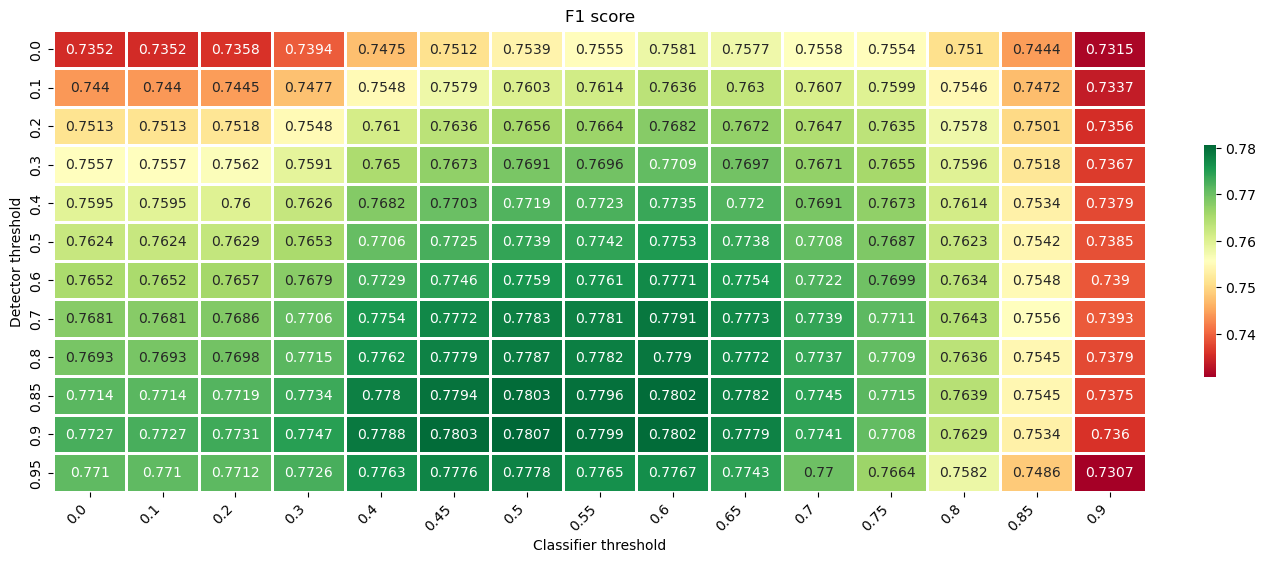

Наилучший F1 0.7807 с detector threshold 0.9 и classifier threshold 0.5


In [13]:
threshold_dtc_clf_metrics = metrics_thresholds_dtc_clf(detector_file, classifier_file,
                                                       detector_thresholds   = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95],
                                                       classifier_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
                                                       visualized=True, file_save='threshold_dtc_clf_metrics.json')

## Построение отчета для модели с лучшими параметрами

In [17]:
def classification_report(detector_file, classifier_file, detector_threshold, classifier_threshold, multiplication_threshold, display_all=None, file_save=None):
    
    model = Builder(device=device,
                    class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                    label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                    detector_path=os.path.join(models_path, detector_file),
                    classifier_path=os.path.join(models_path, classifier_file),
                    detector_threshold=detector_threshold,
                    classifier_threshold=classifier_threshold,
                    multiplication_threshold=multiplication_threshold,
                    debug_mode=False)
    
    dataset_val = load_dataset(dataset_path, os.path.join(dataset_path, 'val_anno.json'))
    dataset_val = add_detection_fo_dataset(model, dataset=dataset_val, visual_score_mode='multiplication')
    
    results = dataset_val.evaluate_detections("detections",
                                              gt_field="ground_truth",
                                              eval_key="eval",
                                              compute_mAP=True,
                                              progress=True,
                                              verbose=False)
    
    clear_output(True)
    
    df = pd.DataFrame(results.report()).T
    df[['precision', 'recall', 'f1-score']] = df[['precision', 'recall', 'f1-score']].round(2)
    df['support'] = df['support'].astype(int)

    if display_all:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
            display(df)

    if file_save:
        with open(os.path.join(metrics_path, file_save), 'w') as f:
            json.dump(results.report(), f)

    return df

In [18]:
pipeline_metrics = classification_report(detector_file, classifier_file, detector_threshold=0.9, classifier_threshold=0.5, multiplication_threshold=0, display_all=True, file_save='pipeline_metrics.json')

,precision,recall,f1-score,support
1_1,0.00,0.00,0.00,3
1_10,1.00,0.75,0.86,4
1_11,0.50,0.31,0.39,35
1_11_1,0.50,0.28,0.36,36
1_12,0.54,0.35,0.42,20
1_12_2,0.50,0.25,0.33,16
1_13,0.00,0.00,0.00,6
1_14,0.83,0.56,0.67,9
1_15,0.50,0.08,0.14,12
1_16,0.48,0.39,0.43,31


In [19]:
# Наименее точно найденные классы
pipeline_metrics.sort_values('f1-score').head(50)

,precision,recall,f1-score,support
1_1,0.00,0.00,0.00,3
1_27,0.00,0.00,0.00,7
1_30,0.00,0.00,0.00,0
5_12,0.00,0.00,0.00,1
5_17,0.00,0.00,0.00,1
1_6,0.00,0.00,0.00,0
1_7,0.00,0.00,0.00,2
8_6_2,0.00,0.00,0.00,2
7_15,0.00,0.00,0.00,3
8_1_3,0.00,0.00,0.00,4
